<a href="https://colab.research.google.com/github/Pavan4468/calculator-using-react-js/blob/main/Predicting_Disease_Outbreaks_corona_virus_2019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 8.52M/8.52M [00:00<00:00, 43.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/sudalairajkumar/novel-corona-virus-2019-dataset/versions/151
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276 entries, 0 to 275
Columns: 498 entries, Province/State to 5/29/21
dtypes: float64(2), int64(494), object(2)
memory usage: 1.0+ MB
None

First 5 rows:
  Province/State Country/Region       Lat       Long  1/22/20  1/23/20  \
0            NaN    Afghanistan  33.93911  67.709953        0        0   
1            NaN        Albania  41.15330  20.168300        0        0   
2            NaN        Algeria  28.03390   1.659600        0        0   
3            NaN        Andorra  42.50630   1.521800        0        0   
4            NaN         Angola -11.20270  17.873900        0        0   

   1/24/20  1/25/20  1/26/20  1/27/20  ...  5/20/21  5/21/21  5/22/21  \
0        0        0        0        0  ...    64575    65080    65486   
1        0        0        0        0  ...   132118   132153   132176   
2 

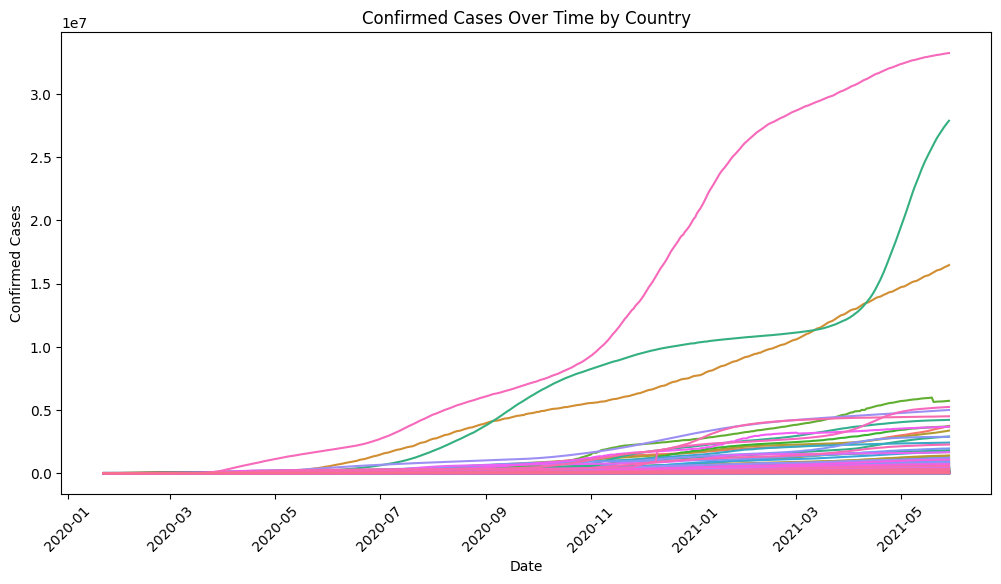

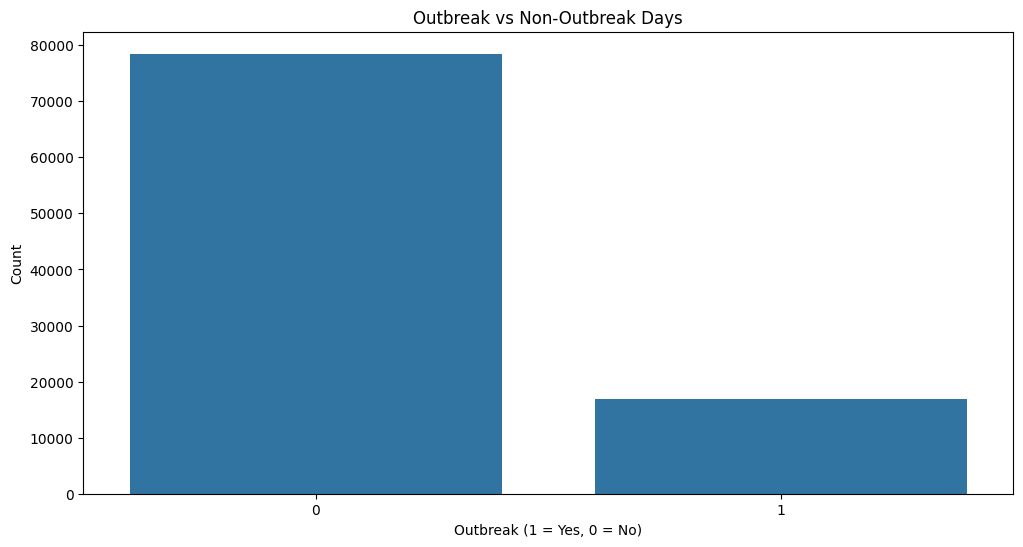


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15732
           1       1.00      1.00      1.00      3337

    accuracy                           1.00     19069
   macro avg       1.00      1.00      1.00     19069
weighted avg       1.00      1.00      1.00     19069


Confusion Matrix:
[[15732     0]
 [    0  3337]]

Feature Importance:
          Feature  Importance
1  Daily_Increase    0.762069
0       Confirmed    0.231554
3           Month    0.005876
2     Day_of_Week    0.000261
4             Day    0.000241


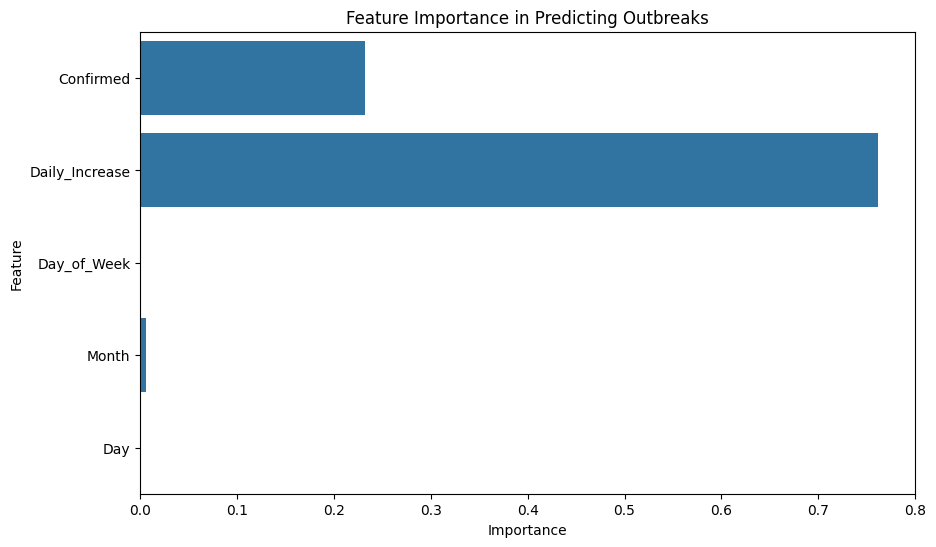


Prediction for next day: No Outbreak


In [ ]:
# Step 1: Install necessary libraries
!pip install kagglehub

# Step 2: Import libraries
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Step 3: Download the dataset
path = kagglehub.dataset_download("sudalairajkumar/novel-corona-virus-2019-dataset")
print("Path to dataset files:", path)

# Step 4: Load the dataset
# Assuming 'time_series_covid_19_confirmed.csv' is one of the files in the dataset
# Adjust the file name based on the actual dataset contents
data_file = f"{path}/time_series_covid_19_confirmed.csv"
df = pd.read_csv(data_file)

# Step 5: Explore the dataset
print("Dataset Info:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())

# Step 6: Data Preprocessing
# Drop unnecessary columns like 'Lat' and 'Long' for simplicity
df = df.drop(columns=['Lat', 'Long'], errors='ignore')

# Melt the dataframe to convert dates into rows (time-series format)
date_columns = [col for col in df.columns if '/' in col]  # Identify date columns
df_melted = pd.melt(df, id_vars=['Province/State', 'Country/Region'],
                    value_vars=date_columns, var_name='Date', value_name='Confirmed')

# Convert 'Date' to datetime
df_melted['Date'] = pd.to_datetime(df_melted['Date'], format='%m/%d/%y')

# Aggregate by date and country (sum confirmed cases)
df_agg = df_melted.groupby(['Country/Region', 'Date'])['Confirmed'].sum().reset_index()

# Step 7: Feature Engineering
# Calculate daily increase in cases
df_agg = df_agg.sort_values(['Country/Region', 'Date'])
df_agg['Daily_Increase'] = df_agg.groupby('Country/Region')['Confirmed'].diff().fillna(0)

# Define an "outbreak" as a daily increase greater than a threshold (e.g., 1000 cases)
threshold = 1000
df_agg['Outbreak'] = (df_agg['Daily_Increase'] > threshold).astype(int)

# Add time-based features
df_agg['Day_of_Week'] = df_agg['Date'].dt.dayofweek
df_agg['Month'] = df_agg['Date'].dt.month
df_agg['Day'] = df_agg['Date'].dt.day

# Step 8: Exploratory Data Analysis (EDA)
# Plot total confirmed cases over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_agg, x='Date', y='Confirmed', hue='Country/Region', legend=False)
plt.title('Confirmed Cases Over Time by Country')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.xticks(rotation=45)
plt.show()

# Plot outbreak occurrences
plt.figure(figsize=(12, 6))
sns.countplot(data=df_agg, x='Outbreak')
plt.title('Outbreak vs Non-Outbreak Days')
plt.xlabel('Outbreak (1 = Yes, 0 = No)')
plt.ylabel('Count')
plt.show()

# Step 9: Prepare data for modeling
# Select features and target
features = ['Confirmed', 'Daily_Increase', 'Day_of_Week', 'Month', 'Day']
X = df_agg[features]
y = df_agg['Outbreak']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 10: Build and train the model (Random Forest Classifier)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Step 11: Make predictions
y_pred = model.predict(X_test_scaled)

# Step 12: Evaluate the model
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Step 13: Feature Importance
feature_importance = pd.DataFrame({'Feature': features, 'Importance': model.feature_importances_})
print("\nFeature Importance:")
print(feature_importance.sort_values('Importance', ascending=False))

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='Importance', y='Feature')
plt.title('Feature Importance in Predicting Outbreaks')
plt.show()

# Step 14: Predict future outbreaks (example for next day)
# Use the last row of data as a base
last_row = df_agg.tail(1)[features].copy()
last_row['Daily_Increase'] = last_row['Daily_Increase'] + 500  # Simulate increase
last_row['Day'] = (last_row['Day'] + 1) % 31  # Increment day
last_row_scaled = scaler.transform(last_row)
prediction = model.predict(last_row_scaled)
print(f"\nPrediction for next day: {'Outbreak' if prediction[0] == 1 else 'No Outbreak'}")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
